In [1]:
rm(list=ls())
options(jupyter.plot_scale=1)
library('cobalt')
library('stringr')

setwd("C:/Users/peppu/Documents/MyPythonProject/BayesianInference/Assignment_Mealli")

Warning message:
"package 'cobalt' was built under R version 4.0.5"
 cobalt (Version 4.3.1, Build Date: 2021-03-30 09:50:18 UTC)

Warning message:
"package 'stringr' was built under R version 4.0.5"


#### 1 - Load the dataset in R. Temporarily remove the outcome, OUTCOME, from the data set.

In [2]:
data = read.table("TrainingLux.txt",header=TRUE)
y = data$Outcome
Z = data$TREAT
X_treat = within(data, rm('Outcome'))
X = within(X_treat, rm('TREAT'))
head(X)

# Correct specification for categorical variables. Not needed here because they are binaries
# XXX = transform(X_TREAT, 
# gender = as.factor(gender),
# married = as.factor(married),
# natio1 = as.factor(natio1),
# natio2 = as.factor(natio2),
# natio3 = as.factor(natio3),
# natio4 = as.factor(natio4),
# natio5 = as.factor(natio5),
# educ1 = as.factor(educ1),
# educ2 = as.factor(educ2),
# educ3 = as.factor(educ3),
# EmployLevel1 = as.factor(EmployLevel1), 
# EmployLevel2 = as.factor(EmployLevel2), 
# EmployLevel3 = as.factor(EmployLevel3), 
# EmployLevel4 = as.factor(EmployLevel4), 
# EmployLevel5 = as.factor(EmployLevel5), 
# skill = as.factor(skill),
# sector0 = as.factor(sector0),
# sector1 = as.factor(sector1),
# sector2 = as.factor(sector2),
# sector3 = as.factor(sector3),
# sector4 = as.factor(sector4),
# work_12 = as.factor(work_12))

,age,gender,married,natio1,natio2,natio3,natio4,natio5,educ1,educ2,...,EmployLevel4,EmployLevel5,skill,sector0,sector1,sector2,sector3,sector4,work_12,nb_mthbf_12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,60,1,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,12
4,60,0,1,0,1,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,12
8,63,1,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,1,12
11,60,0,1,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,12
13,59,0,1,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
16,60,1,0,0,0,1,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0


#### 2 - For each covariate, display the mean within each treatment group and the standardized difference in a table.

In [3]:
meanT = apply(X[Z==1,],2,mean) # Average of the treated
meanC = apply(X[Z==0,],2,mean) # Average of the controls
varT = apply(X[Z==1,],2,var) # Variance of the treated
varC = apply(X[Z==0,],2,var) # Variance of the controls

meandiff = meanT - meanC
StMeanDiff = meandiff/ sqrt((varT+varC)/2) # STANDARDIZED DIFFERENCE BETWEEN MEANS
StMeanDiffTtest = meandiff/sqrt(varT/sum(Z==1) + varC/sum(Z==0)) # STANDARDIZED DIFFERENCE BETWEEN MEANS (t-test)
range_var = apply(X,2,max)-apply(X,2,min) # Range of the variable

round(cbind(meanT, meanC, meandiff, StMeanDiff,StMeanDiffTtest,range_var),3)

,meanT,meanC,meandiff,StMeanDiff,StMeanDiffTtest,range_var
age,36.826,34.435,2.391,0.231,8.469,54
gender,0.649,0.471,0.178,0.364,12.037,1
married,0.556,0.420,0.136,0.274,8.852,1
natio1,0.055,0.308,-0.253,-0.693,-34.134,1
natio2,0.270,0.301,-0.031,-0.068,-2.247,1
natio3,0.274,0.194,0.080,0.189,5.800,1
natio4,0.187,0.081,0.106,0.316,8.906,1
natio5,0.214,0.116,0.097,0.265,7.747,1
educ1,0.277,0.272,0.005,0.011,0.363,1
educ2,0.340,0.495,-0.155,-0.318,-10.565,1


#### 3 - Estimate a propensity score for each unit in the observational study using the fitted values from a logistic regression with main effects for all of the covariates contained in the data set (leave out transformations and interactions here, but we would generally want to explore these other terms). Compare graphically the distributions of estimated propensity scores within the treatment groups and explain what you see.

In [4]:
model_ps = glm(TREAT~., data=X_treat, family=binomial(link=logit)) # Propensity score estimation
log_ps = predict.glm(model_ps) # equalt to log(pscores/(1-pscores)) 
pscore = model_ps$fitted # Propensity score
# summary(model_ps)

Mlp.c<-mean(log_ps[Z==0]) # Mean log ps of the controls
Mlp.t<-mean(log_ps[Z==1]) # Mean log ps of the treated
Vlp.c<-var(log_ps[Z==0]) # Var log ps of the controls
Vlp.t<-var(log_ps[Z==1]) # Var log ps of the tread 
 
StandDiff_log_ps = (Mlp.t-Mlp.c)/sqrt((Vlp.t+Vlp.c)/2)
StandDiff_log_ps # Standard difference in LOG_PS

[1] 1.47183

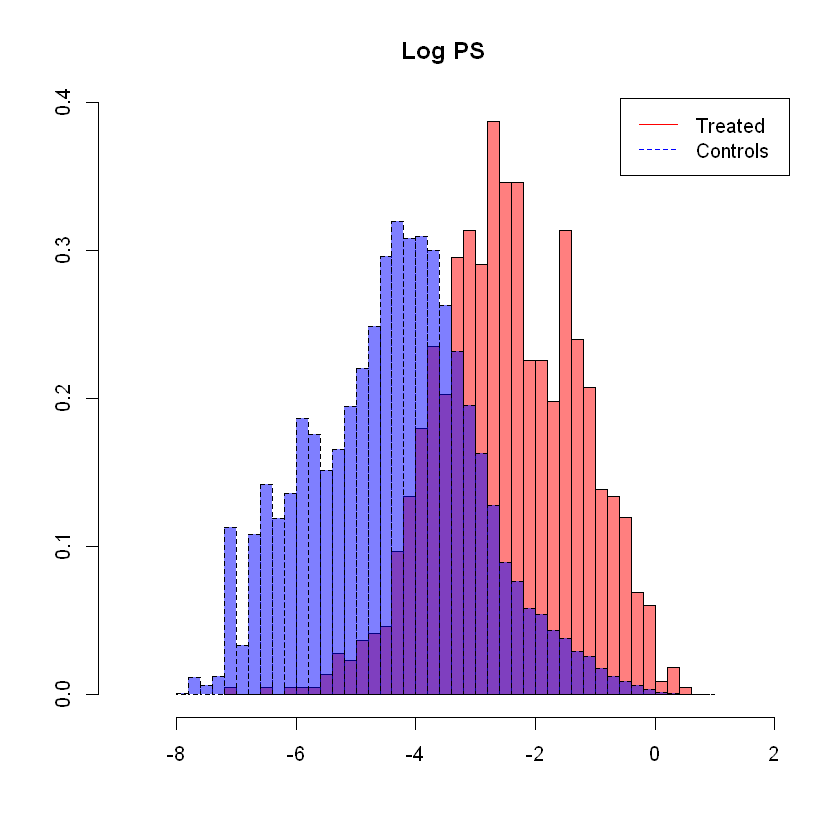

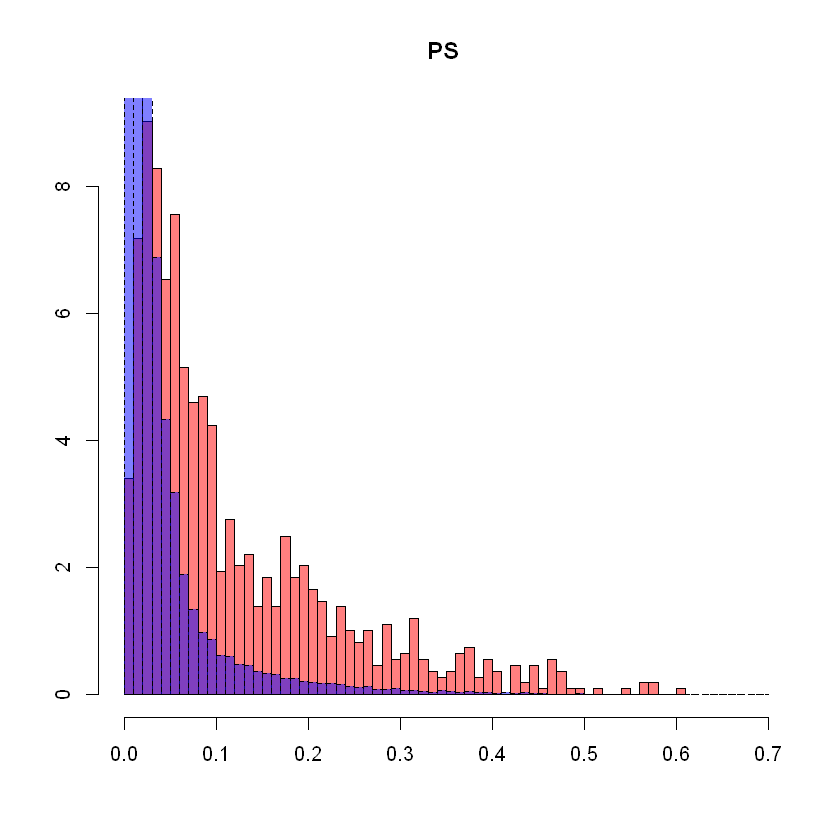

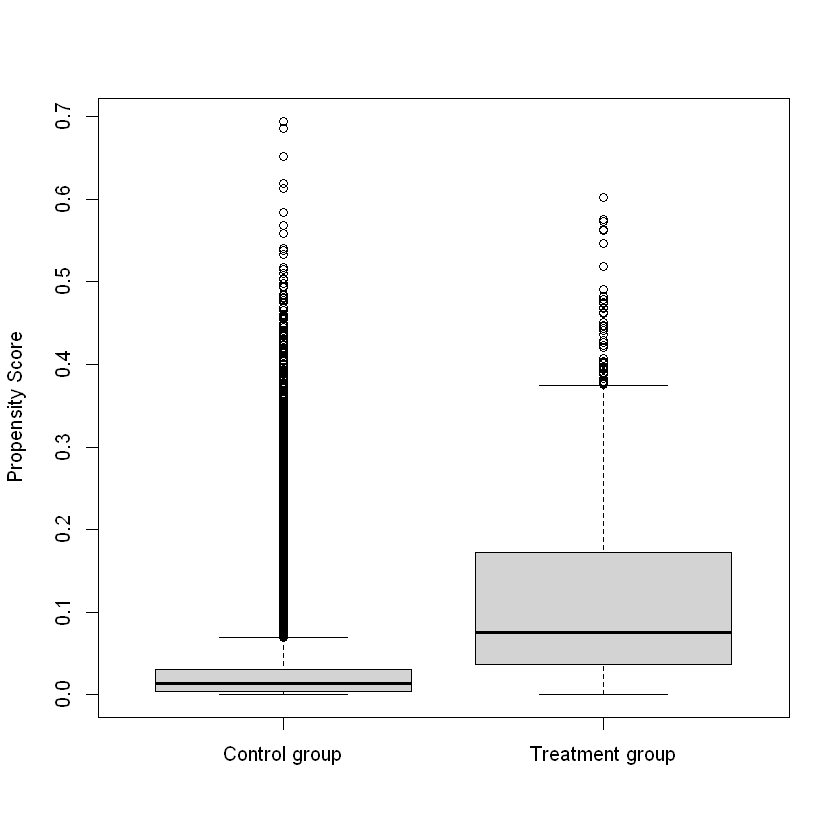

In [5]:
x_low_lim = min(log_ps) - 1 # Set the minimum for the breakpoints
x_up_lim = max(log_ps) + 1 # Set the maximum for the breakpoints

par(mfcol=c(1,1))
hist(log_ps[Z==1], freq=FALSE, main="Log PS",xlab="",ylab="",breaks=50,
     xlim=c(x_low_lim,x_up_lim), col=rgb(1,0,0,0.5))
hist(log_ps[Z==0], freq=FALSE, breaks=50,
     xlim=c(x_low_lim,x_up_lim), add=TRUE, lwd=2, 
      col=rgb(0,0,1,0.5), lty=2,)
par(xpd=TRUE)
legend("topright",
       legend = c("Treated", "Controls"),
       lty = c(1, 2),
       col = c("red", "blue"),
       cex = 1)
par(xpd=FALSE)

x_low_lim = min(pscore) - 0.001 # Set the minimum for the breakpoints
x_up_lim = max(pscore) + 0.001 # Set the maximum for the breakpoints

hist(pscore[Z==1], freq=FALSE, main="PS",xlab="",ylab="",breaks=50,
     xlim=c(x_low_lim,x_up_lim), col=rgb(1,0,0,0.5))
hist(pscore[Z==0], freq=FALSE, breaks=50,
     xlim=c(x_low_lim,x_up_lim), add=TRUE, lwd=2, col=rgb(0,0,1,0.5), lty=2,)

boxplot(pscore~Z, ylab="Propensity Score",
        names=c("Control group",
                "Treatment group"), xlab="")

The mean of the propensity score is different between the two groups and this is an indication of plausible fit of the propensity score. It is necessary to note that even for treated group the propensity score is not close to 1 (value I expected); this could be probably due to very high number of controls vs treated. This behavior of the fitted PS should not be a problem since PS is used to create groups and not for predictiont task. <br>
In the 1st and 3rd subplot it is clear that there is an high overlap of PS between treated and untreated.

#### 4. What are the implications of the fact that the propensity score is a balancing score?
COPIA da slide 3 e 5

# TRIMMING AND SUBCLASSIFICATION ON PROPENSITY SCORE
Now assess balance and create balanced groups.

#### 5 - In order to do so, first discard control units with estimated propensity scores lower than the minimum of the active treated units' estimated propensity scores or higher than the maximum of the active treatment units' estimated propensity scores.
#### How many units did you discard? Why is is important to discarding these units?

In [6]:
trim_bool = (log_ps>=min(log_ps[Z==1])) & (log_ps<=max(log_ps[Z==1]))
X_treat_trim = X_treat[trim_bool,] # Trimmed data
X_trim = X[trim_bool,] # Trimmed covariates
y_trim = y[trim_bool]
Z_trim = X_treat_trim$TREAT # Trimmed treatment
print('Number of filtered points')
dim(X_treat)[1]- dim(X_treat_trim)[1]

[1] "Number of filtered points"


[1] 370

It is important to discard these values because these values "do not overlap"; basically there are no treated units with that propensity score, meaning that the covariates are very different.

In [7]:
meanT_trim = apply(X_trim[Z_trim==1,],2,mean) # Average of the treated
meanC_trim = apply(X_trim[Z_trim==0,],2,mean) # Average of the controls
varT_trim = apply(X_trim[Z_trim==1,],2,var) # Variance of the treated
varC_trim = apply(X_trim[Z_trim==0,],2,var) # Variance of the controls

meandiff_trim = meanT_trim - meanC_trim # Difference in mean
StMeanDiff_trim = meandiff_trim/ sqrt((varT_trim+varC_trim)/2) # STANDARDIZED DIFFERENCE BETWEEN MEANS
StMeanDiffTtest_trim = meandiff_trim/sqrt(varT_trim/sum(Z_trim==1) + varC_trim/sum(Z_trim==0)) # STANDARDIZED DIFFERENCE BETWEEN MEANS (t-test)
range_var_trim = apply(X_trim,2,max)-apply(X_trim,2,min)

round(cbind(meanT_trim, meanC_trim, meandiff_trim, StMeanDiff_trim,StMeanDiffTtest_trim,range_var_trim),3)

,meanT_trim,meanC_trim,meandiff_trim,StMeanDiff_trim,StMeanDiffTtest_trim,range_var_trim
age,36.826,34.597,2.229,0.216,7.894,54
gender,0.649,0.476,0.173,0.353,11.687,1
married,0.556,0.425,0.131,0.265,8.552,1
natio1,0.055,0.300,-0.245,-0.676,-33.088,1
natio2,0.270,0.304,-0.034,-0.076,-2.498,1
natio3,0.274,0.196,0.077,0.183,5.636,1
natio4,0.187,0.082,0.106,0.313,8.834,1
natio5,0.214,0.118,0.096,0.261,7.644,1
educ1,0.277,0.275,0.002,0.005,0.168,1
educ2,0.340,0.490,-0.150,-0.307,-10.207,1


#### 6 - Using the units remaining after 5, create five subclasses based on the estimated propensity score. You are allowed to choose size and bounds of the subclasses. You are supposed to create the best subclasses based on your own reasoning. Create a table showing the number of treated and control units within each of the five subclasses. Briefly comment and explain your choice.

In [8]:
model_ps_trim = glm(TREAT~., data=X_treat_trim, family=binomial(link=logit)) # Estimate a new propensity score
log_ps_trim = predict.glm(model_ps_trim)
pscore_trim = model_ps_trim$fitted

ps_table_results = function(breaks, log_ps_trim, X_trim,  Z_trim, min_in_breaks = FALSE, max_in_breaks = FALSE){
    bins = rep(NA,nrow(X_trim))
    
    if (min_in_breaks==TRUE){
        prev_i = breaks[1]
        breaks = breaks[2:length(breaks)]
    }
    else{
        prev_i = min(log_ps_trim)-0.000001
    }
    
    if (max_in_breaks==TRUE){
        new_breaks = breaks
    }
    else{
        new_breaks = c(breaks,max(log_ps_trim)+0.000001)
    }
    
    
    j = 1
    for (i in new_breaks){
        sel_bin = (log_ps_trim>prev_i & log_ps_trim<=i)
        bins[sel_bin] = j

        sel_bin_treat = Z_trim==1 & sel_bin
        sel_bin_control = Z_trim==0 & sel_bin

        meanT_trim = apply(X_trim[sel_bin_treat,],2,mean)
        meanC_trim = apply(X_trim[sel_bin_control,],2,mean)
        varT_trim = apply(X_trim[sel_bin_treat,],2,var)
        varC_trim = apply(X_trim[sel_bin_control,],2,var)
        meandiff_trim = meanT_trim - meanC_trim
        if (j==1){
            mean_df = data.frame(mean_t_1=meanT_trim, mean_c_1 = meanC_trim)
            var_df = data.frame(var_t_1=varT_trim, var_c_1 = varC_trim)
            std_diff_df = data.frame(std_diff_1=meandiff_trim/ sqrt((varT_trim+varC_trim)/2))
            std_diff_ttest_df = data.frame(std_diff_t_1=meandiff_trim/sqrt(varT_trim/sum(Z_trim==1) + varC_trim/sum(Z_trim==0)))
        }
        else{
            std_diff_df$temp = meandiff_trim/ sqrt((varT_trim+varC_trim)/2)  # STANDARDIZED DIFFERENCE BETWEEN MEANS
            colnames(std_diff_df)[length(colnames(std_diff_df))] = paste('std_diff', j, sep="_")
            std_diff_ttest_df$temp = meandiff_trim/sqrt(varT_trim/sum(Z_trim==1) + varC_trim/sum(Z_trim==0)) # STANDARDIZED DIFFERENCE BETWEEN MEANS (t-test)
            colnames(std_diff_ttest_df)[length(colnames(std_diff_ttest_df))] = paste('std_diff_t', j, sep="_")
            mean_df$temp = meanT_trim # 
            colnames(mean_df)[length(colnames(mean_df))] = paste('mean_t', j, sep="_")
            mean_df$temp = meanC_trim #
            colnames(mean_df)[length(colnames(mean_df))] = paste('mean_c', j, sep="_")
            var_df$temp = varT_trim # 
            colnames(var_df)[length(colnames(var_df))] = paste('var_t', j, sep="_")
            var_df$temp = varC_trim #
            colnames(var_df)[length(colnames(var_df))] = paste('var_c', j, sep="_")
        }

        j = j+1
        prev_i = i
    }
    
    return(list(mean_df=mean_df, var_df=var_df,std_diff_df=std_diff_df, std_diff_ttest_df=std_diff_ttest_df, bins=bins))
    }
breaks = quantile(log_ps_trim, c(0.72, 0.86, 0.925, 0.97))
ps_res = ps_table_results(breaks, log_ps_trim, X_trim,  Z_trim, min_in_breaks=FALSE, max_in_breaks=FALSE)
std_diff_df = ps_res$std_diff_df
bins = ps_res$bins
table(bins, Z_trim)
table(bins)

    Z_trim
bins     0     1
   1 23790   209
   2  4461   208
   3  1943   221
   4  1292   208
   5   761   239

bins
    1     2     3     4     5 
23999  4669  2164  1500  1000 

I modified the quantile values to obtain 5 groups with the same number of treated units.

#### 7. Separately for each subclass created in 6, calculate the mean within each treatment group for each covariate. Present the results in a table. Briefly describe what you see.

In [9]:
round(ps_res$mean_df,2)
# round(sqrt(ps_res$var_df),2)
round(std_diff_df,2)

,mean_t_1,mean_c_1,mean_t_2,mean_c_2,mean_t_3,mean_c_3,mean_t_4,mean_c_4,mean_t_5,mean_c_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,34.35,33.68,35.95,37.73,35.65,36.96,38.09,35.88,39.74,36.61
gender,0.50,0.41,0.63,0.64,0.61,0.69,0.69,0.64,0.79,0.78
married,0.46,0.37,0.50,0.59,0.56,0.58,0.56,0.51,0.69,0.58
natio1,0.22,0.39,0.04,0.06,0.02,0.04,0.00,0.01,0.00,0.00
natio2,0.35,0.33,0.34,0.19,0.30,0.30,0.30,0.38,0.08,0.17
natio3,0.22,0.17,0.28,0.30,0.25,0.23,0.34,0.29,0.28,0.30
natio4,0.08,0.04,0.18,0.21,0.23,0.20,0.17,0.16,0.26,0.28
natio5,0.12,0.08,0.16,0.23,0.19,0.23,0.19,0.16,0.37,0.25
educ1,0.25,0.27,0.25,0.28,0.29,0.24,0.30,0.31,0.29,0.31


,std_diff_1,std_diff_2,std_diff_3,std_diff_4,std_diff_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,0.07,-0.18,-0.13,0.22,0.33
gender,0.19,-0.02,-0.17,0.11,0.04
married,0.18,-0.19,-0.04,0.11,0.23
natio1,-0.39,-0.09,-0.10,-0.06,NaN
natio2,0.06,0.32,0.01,-0.17,-0.27
natio3,0.15,-0.04,0.05,0.10,-0.04
natio4,0.19,-0.08,0.06,0.03,-0.04
natio5,0.15,-0.18,-0.09,0.07,0.27
educ1,-0.06,-0.06,0.13,-0.03,-0.04


There are two main points i would like to raise:
- Unbalance on AGE, group 5. This group contains a difference in the mean between C and T of about 3 years; all other groups are more balanced.
- "natio1" and "sector0" units are all "zeros" in group 5; is this acceptable?

#### 7 - b Summarize the average balance achieved for each covariate by averaging the differences in means across subclasses, weighting by the NUMBER OF UNITS IN THE ACTIVE TREATMENT GROUP in each subclass. Why would we weight by the number of active treatment units? Display these covariate means, averaged across the subclasses, in Table 1.

In [10]:
treat_tab = table(bins, Z_trim)
treatweights = treat_tab[,2]/sum(treat_tab[,2]) # weights based on number of treated in each group

indx = grepl('mean_t', colnames(ps_res$mean_df))
bmeanT =t(ps_res$mean_df[indx])
indx = grepl('mean_c', colnames(ps_res$mean_df))
bmeanC =t(ps_res$mean_df[indx])
indx = grepl('var_t', colnames(ps_res$var_df))
bvarT =t(ps_res$mean_df[indx])
indx = grepl('var_c', colnames(ps_res$var_df))
bvarC =t(ps_res$mean_df[indx])

meanT_bt = t(bmeanT)%*%treatweights 
meanC_bt = t(bmeanC)%*%treatweights
meandiff_trim_block = t(bmeanT-bmeanC)%*%treatweights
round(cbind(meanC_bt, meanT_bt, meandiff_trim_block), 2)
###################################### different from R script of class (the normalization is not calculated)
StMeanDiff_block_t = meandiff_trim_block/sqrt({varT_trim+varC_trim}/2)
###################################### different from R script of class (the normalization is not calculated)
# maybe the following?
# t((bmeanT-bmeanC)/sqrt({bvarT+bvarC}/2))%*%treatweights

age,36.19,36.83,0.63
gender,0.64,0.65,0.01
married,0.53,0.56,0.03
natio1,0.10,0.06,-0.04
natio2,0.27,0.27,0.00
natio3,0.26,0.27,0.02
natio4,0.18,0.19,0.01
natio5,0.19,0.21,0.02
educ1,0.28,0.28,-0.01
educ2,0.35,0.34,-0.01
educ3,0.37,0.38,0.01


In [11]:
# Increase balance table
round(cbind(StMeanDiff,StMeanDiff_block_t,(StMeanDiff-StMeanDiff_block_t)/StMeanDiff),3)

,StMeanDiff,,
age,0.231,0.061,0.735
gender,0.364,0.028,0.922
married,0.274,0.058,0.787
natio1,-0.693,-0.117,0.831
natio2,-0.068,-0.003,0.953
natio3,0.189,0.041,0.784
natio4,0.316,0.019,0.941
natio5,0.265,0.055,0.792
educ1,0.011,-0.012,2.032
educ2,-0.318,-0.013,0.960


The units MUST be weighted on active treatment units because otherwise group 1 that has a thousands of units more than other groups will be the one "driving" all the results.

#### 8 - Use descriptive tools (graphs and statistics) to assess covariate balance.

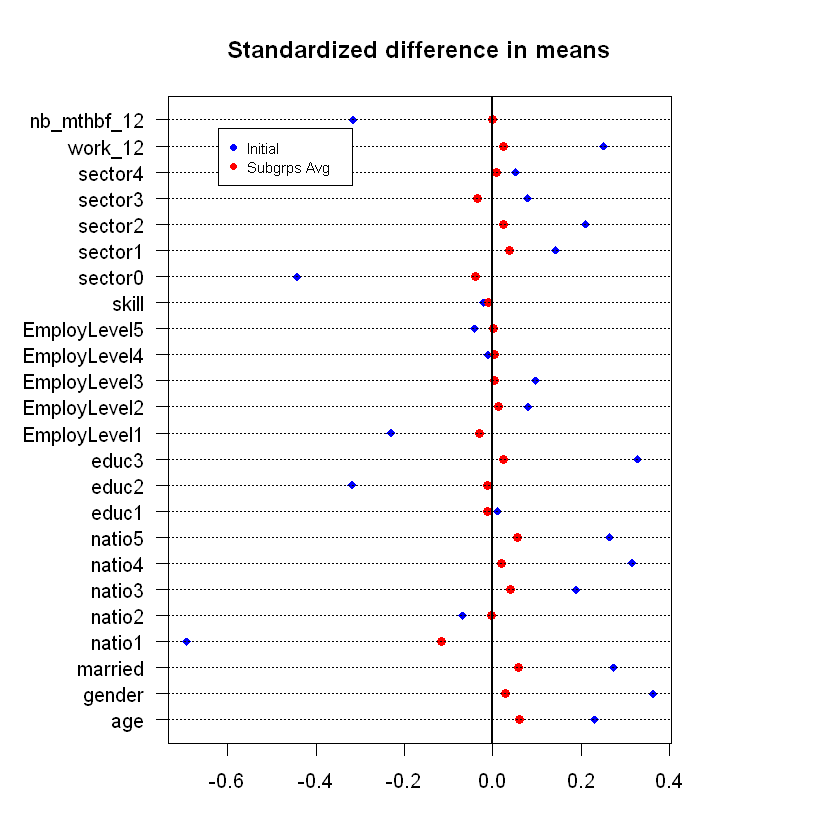

In [12]:
#### LOVE-PLOTS

# ALL
par(mar=c(4, 7, 4, 7), xpd=FALSE)
plot(StMeanDiff, 1:dim(X_trim)[2],  xlab=NA, ylab=NA, yaxt="n",
     xlim=c(min(c(StMeanDiff, StMeanDiff_block_t)),
            max(c(StMeanDiff, StMeanDiff_block_t))),
     pch=18, col="blue",
     main="Standardized difference in means", sub="Binary covariates")
points(StMeanDiff_block_t, 1:dim(X_trim)[2], col="red", pch=19)
axis(2, labels=names(X_trim),at=1:dim(X_trim)[2], las=1)
abline(h=1:dim(X_trim)[2], lty="dotted")
abline(v=0, lwd=2)
par(xpd=TRUE)
legend("topleft",
       inset = c(0.1,0.05),
       legend = c("Initial", "Subgrps Avg"),
       pch = c(19, 19),
       col = c("blue", "red"),
       cex = 0.75)
par(xpd=FALSE)

#### 9 - What might we have changed about the propensity score model and/or subclassification method used in 6 in order to achieve better covariate balance? Change the propensity score model or subclassification method in at least one way (Hint: you may create more subclasses or change the specification of the propensity score by including interaction or nonlinear terms). Graphically summarize the covariate balance achieved and compare it to the balance achieved by your design to the balance achieved by the subclasses you created in 6. Briefly explain the motivation for your design and whether the resulting balance was as you expected. (If your design did not achieve the balance that you expected, that is okay.)

In [13]:
breaks_new = quantile(log_ps_trim, c(0.75, 0.8, 0.84,0.872,0.898,0.915, 0.938, 0.96))
ps_res_new = ps_table_results(breaks_new, log_ps_trim, X_trim,  Z_trim, min_in_breaks=TRUE, max_in_breaks=TRUE)
bins_new = ps_res_new$bins

X_trim_new = X_trim[!is.na(bins_new),]
Z_trim_new = Z_trim[!is.na(bins_new)]
y_trim_new = y_trim[!is.na(bins_new)]
varT_trim_new = apply(X_trim_new[Z_trim_new==1,],2,var) # Variance of the treated
varC_trim_new = apply(X_trim_new[Z_trim_new==0,],2,var) # Variance of the controls

std_diff_df_new = ps_res_new$std_diff_df
table(bins_new, Z_trim)
table(bins_new)

treat_tab_new = table(bins_new, Z_trim)
treatweights_new = treat_tab_new[,2]/sum(treat_tab_new[,2]) # weights based on number of treated in each group

indx = grepl('mean_t', colnames(ps_res_new$mean_df))
bmeanT_new =t(ps_res_new$mean_df[indx])
indx = grepl('mean_c', colnames(ps_res_new$mean_df))
bmeanC_new =t(ps_res_new$mean_df[indx])
indx = grepl('var_t', colnames(ps_res_new$var_df))
bvarT_new =t(ps_res_new$mean_df[indx])
indx = grepl('var_c', colnames(ps_res_new$var_df))
bvarC_new =t(ps_res_new$mean_df[indx])

meanT_bt_new = t(bmeanT_new)%*%treatweights_new
meanC_bt_new = t(bmeanC_new)%*%treatweights_new
meandiff_trim_block_new = t(bmeanT_new-bmeanC_new)%*%treatweights_new

# round(ps_res_new$mean_df,2)
# # round(sqrt(ps_res$var_df),2)
# round(std_diff_df,2)
# round(cbind(meanC_bt_new, meanT_bt_new, meandiff_trim_block_new), 2)

###################################### different from R script of class (the normalization is not calculated)
StMeanDiff_block_t_new = meandiff_trim_block_new/sqrt({varT_trim+varC_trim}/2)
StMeanDiff_block_t_new = meandiff_trim_block_new/sqrt({varT_trim_new+varC_trim_new}/2)
###################################### different from R script of class (the normalization is not calculated)
# maybe the following?
# t((bmeanT-bmeanC)/sqrt({bvarT+bvarC}/2))%*%treatweights

        Z_trim
bins_new    0    1
       1 1598   71
       2 1260   71
       3  994   73
       4  792   74
       5  489   77
       6  680   87
       7  639   94

bins_new
   1    2    3    4    5    6    7 
1669 1331 1067  866  566  767  733 

In [14]:
# Increase balance table
round(cbind(StMeanDiff,StMeanDiff_block_t_new,(StMeanDiff-StMeanDiff_block_t_new)/StMeanDiff),3)

,StMeanDiff,,
age,0.231,-0.032,1.138
gender,0.364,-0.055,1.151
married,0.274,-0.048,1.174
natio1,-0.693,-0.084,0.879
natio2,-0.068,0.057,1.829
natio3,0.189,0.067,0.643
natio4,0.316,0.000,1.000
natio5,0.265,-0.101,1.383
educ1,0.011,0.048,-3.292
educ2,-0.318,0.015,1.048


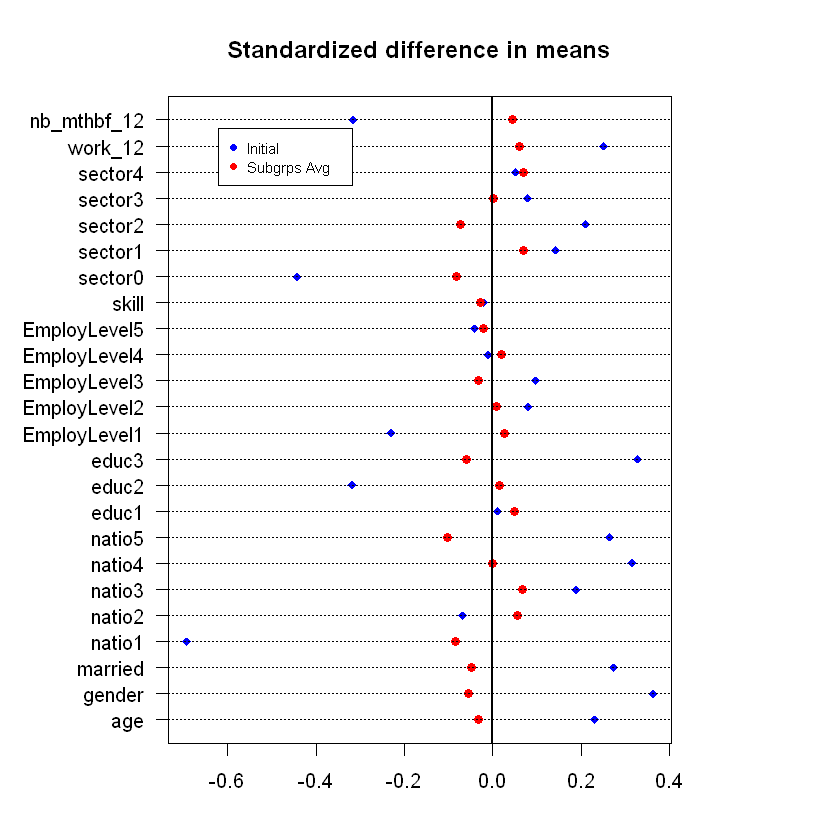

In [15]:
#### LOVE-PLOTS

# ALL
par(mar=c(4, 7, 4, 7), xpd=FALSE)
plot(StMeanDiff, 1:dim(X_trim)[2],  xlab=NA, ylab=NA, yaxt="n",
     xlim=c(min(c(StMeanDiff, StMeanDiff_block_t_new)),
            max(c(StMeanDiff, StMeanDiff_block_t_new))),
     pch=18, col="blue",
     main="Standardized difference in means", sub="Binary covariates")
points(StMeanDiff_block_t_new, 1:dim(X_trim_new)[2], col="red", pch=19)
axis(2, labels=names(X_trim),at=1:dim(X_trim_new)[2], las=1)
abline(h=1:dim(X_trim_new)[2], lty="dotted")
abline(v=0, lwd=2)
par(xpd=TRUE)
legend("topleft",
       inset = c(0.1,0.05),
       legend = c("Initial", "Subgrps Avg"),
       pch = c(19, 19),
       col = c("blue", "red"),
       cex = 0.75)
par(xpd=FALSE)

I decided to have smaller groups because I expected to have an higher balance; I needed to discard also some data to have smaller groups. Finally, the new groups are actually more unblanced.

#### 10 - Now that the study design phase is complete, read in the outcome, Outcome.

In [16]:
data = read.table("TrainingLux.txt",header=TRUE)
y = data$Outcome
Z = data$TREAT
X_treat = within(data, rm('Outcome'))
X = within(X_treat, rm('TREAT'))

#### 11 - Naively pretending that this observational study was actually a completely randomized experiment, and ignoring covariates, calculate a Neyman estimate of the average treatment effect and a large sample 95% interval and enter both in a table.

In [17]:
naive_neyman = function(X, Z, y,  Z_trim, min_in_breaks = FALSE, max_in_breaks = FALSE){
    
    # Naive Neyman
    nT = sum(Z)
    nC = nrow(X)-nT

    y1_obs = y[Z==1]
    y0_obs = y[Z==0]
    ATE = mean(y1_obs) - mean(y0_obs)
    ATE_var = var(y1_obs)/nT + var(y0_obs)/nC
    obsLB1 = ATE-1.96*sqrt(ATE_var)
    obsUB1 = ATE+1.96*sqrt(ATE_var)
    out_df = data.frame(ATE_mean=ATE, ATE_lower_bound=obsLB1, ATE_upper_bound=obsUB1)
    return (list(out_df=out_df,ATE=ATE,ATE_var=ATE_var))
    }
d = naive_neyman(X, Z, y)$out_df
round(d,4)

ATE_mean,ATE_lower_bound,ATE_upper_bound
<dbl>,<dbl>,<dbl>
-0.0273,-0.0575,0.0029


#### 12 - Calculate the naive Neyman estimate as in 11, but on the subset of units obtained in 5. Report it in the table and comment briefly.

In [18]:
d_trim = naive_neyman(X_trim, Z_trim, y_trim)$out_df
neyman_tab=rbind(d,d_trim)
rownames(neyman_tab) = c('Naive','Trimmed')
round(neyman_tab,4)

,ATE_mean,ATE_lower_bound,ATE_upper_bound
,<dbl>,<dbl>,<dbl>
Naive,-0.0273,-0.0575,0.0029
Trimmed,-0.0261,-0.0563,0.0041


### COMMENTARE E DIRE CHE SONO SIMILI

#### 13 - Obtain a Neyman point estimate for the treatment effect within each subclass from 6. Estimate the overall treatment eect by averaging across the subclasses, weighting according to the NUMBER OF UNITS IN THE ACTIVE TREATMENT GROUP in each subclass. Provide a 95% large sample confidence interval for the overall estimate by using the fact that (FORMULA). Report the results in the summary table and compare this interval to the other intervals you've obtained, commenting briefly.

In [19]:
w = c()
ate = c()
ate_var = c()
bsort = sort(unique(bins))
for (bin in bsort){
    sel_bool = bins==bin
    w = c(w,sum(sel_bool & Z_trim==1))
    nn = naive_neyman(X_trim[sel_bool,], Z_trim[sel_bool], y_trim[sel_bool])
    ate = c(ate,nn$ATE)
    ate_var = c(ate_var,nn$ATE_var)
}
w = w/sum(w)
d_groups = data.frame(ATE_mean=ate%*%w, ATE_lower_bound=ate%*%w-1.96*ate_var%*%w^2, ATE_upper_bound=ate%*%w+1.96*ate_var%*%w^2)
neyman_tab=rbind(d,d_trim,d_groups)
rownames(neyman_tab) = c('Naive','Trimmed','Stratification')
round(neyman_tab,4)

,ATE_mean,ATE_lower_bound,ATE_upper_bound
,<dbl>,<dbl>,<dbl>
Naive,-0.0273,-0.0575,0.0029
Trimmed,-0.0261,-0.0563,0.0041
Stratification,0.0229,0.0224,0.0234


# COMMENTARE

#### 14 - Obtain a Neyman point estimate and 95% large sample confidence interval based on the design you created in 9.

In [20]:
w = c()
ate = c()
ate_var = c()
bins_filt = bins_new[!is.na(bins_new)]
bsort = sort(unique(bins_filt))
for (bin in bsort){
    sel_bool = bins_filt==bin
    w = c(w,sum(sel_bool & Z_trim_new==1))
    nn = naive_neyman(X_trim_new[sel_bool,], Z_trim_new[sel_bool], y_trim_new[sel_bool])
    ate = c(ate,nn$ATE)
    ate_var = c(ate_var,nn$ATE_var)
}
w = w/sum(w)
d_groups_9 = data.frame(ATE_mean=ate%*%w,
                        ATE_lower_bound=ate%*%w-1.96*ate_var%*%w^2,
                        ATE_upper_bound=ate%*%w+1.96*ate_var%*%w^2)
neyman_tab=rbind(d,d_trim,d_groups,d_groups_9)
rownames(neyman_tab) = c('Naive','Trimmed','Stratification','Stratification_9')
round(neyman_tab,4)

,ATE_mean,ATE_lower_bound,ATE_upper_bound
,<dbl>,<dbl>,<dbl>
Naive,-0.0273,-0.0575,0.0029
Trimmed,-0.0261,-0.0563,0.0041
Stratification,0.0229,0.0224,0.0234
Stratification_9,0.0492,0.0482,0.0502


#### 15 - Discuss the various estimates you obtained.

# Backup

In [ ]:
table(bins, Z_trim)
table(bins)

In [ ]:
max(bins)

In [ ]:
colnames(df)[-1] = paste('std_diff_safsa', j, sep="_")
df

In [ ]:
paste('std_diff_t', 3,sep="_")

In [ ]:
meanT_trim = apply(X_trim[Z_trim==1,],2,mean)
meanC_trim = apply(X_trim[Z_trim==0,],2,mean)
varT_trim = apply(X_trim[Z_trim==1,],2,var)
varC_trim = apply(X_trim[Z_trim==0,],2,var)

meandiff_trim = meanT_trim - meanC_trim
StMeanDiff_trim = meandiff_trim/ sqrt((varT_trim+varC_trim)/2)
StMeanDiffTtest_trim = meandiff_trim/sqrt(varT_trim/sum(Z_trim==1) + varC_trim/sum(Z_trim==0))
range_var_trim = apply(X_trim,2,max)-apply(X_trim,2,min)

round(cbind(meanT_trim, meanC_trim, meandiff_trim, StMeanDiff_trim,StMeanDiffTtest_trim,range_var_trim),3)

In [ ]:
a = data.frame(v1=c(10, 20), v2=c("[]", "[]"), v3=c("[[1,2]]","[[1,3]]"))
names(a)=c('v11','v22','v33')
a

In [ ]:
df$treat=0

In [ ]:
XXX = transform(X_TREAT, 
gender = as.factor(gender),
married = as.factor(married),
natio1 = as.factor(natio1),
natio2 = as.factor(natio2),
natio3 = as.factor(natio3),
natio4 = as.factor(natio4),
natio5 = as.factor(natio5),
educ1 = as.factor(educ1),
educ2 = as.factor(educ2),
educ3 = as.factor(educ3),
EmployLevel1 = as.factor(EmployLevel1), 
EmployLevel2 = as.factor(EmployLevel2), 
EmployLevel3 = as.factor(EmployLevel3), 
EmployLevel4 = as.factor(EmployLevel4), 
EmployLevel5 = as.factor(EmployLevel5), 
skill = as.factor(skill),
sector0 = as.factor(sector0),
sector1 = as.factor(sector1),
sector2 = as.factor(sector2),
sector3 = as.factor(sector3),
sector4 = as.factor(sector4),
work_12 = as.factor(work_12))
mod <- glm(TREAT~., data=XXX, family=binomial(link=logit))
summary(mod)

In [ ]:
ps = model_ps$fitted
x_low_lim = min(ps) - 0.001 # Set the minimum for the breakpoints
x_up_lim = max(ps) + 0.001 # Set the maximum for the breakpoints

par(mfcol=c(1,1))
hist(ps[Z==1], freq=FALSE, main="LogPS - Treated versus Control Subjects",
     xlab="",ylab="",breaks=100,xlim=c(x_low_lim,x_up_lim), col=rgb(1,0,0,0.5))
hist(ps[Z==0], freq=FALSE, breaks=100,,xlim=c(x_low_lim,x_up_lim), add=TRUE, lwd=2, 
      col=rgb(0,0,1,0.5), lty=2,)
par(xpd=TRUE)
legend("top",
       legend = c("Treated", "Controls"),
       lty = c(1, 2),
       col = c("red", "blue"),
       cex = 1)
par(xpd=FALSE)

In [ ]:
ncol(X) == qr(X)$rank

In [ ]:
library(MatchIt)
w.out1 <- matchit(TREAT ~ .,
                   data = X_treat, method = "nearest", discard='control')
library(WeightIt)
w.out2 <- weightit(TREAT ~ .,
                   data = X_treat, estimand = "ATT", method = "ps")

In [ ]:
set.cobalt.options(binary = "std")

love.plot(w.out1)
love.plot(w.out2)


In [ ]:
library(WeightIt)
w.out2 <- weightit(TREAT ~ .,
                   data = X_treat_trim, estimand = "ATE", method = "ps")
summary(w.out2)
w.out2 <- weightit(TREAT ~ .,
                   data = X_treat_trim, estimand = "ATT", method = "ps")
summary(w.out2)


In [ ]:
love.plot(w.out2)


In [ ]:

# ## Binary data
# binary_cols = c(3:dim(X_trim)[2]-1)
# StMeanDiff_binary <- StMeanDiff[binary_cols]
# StMeanDiff_block_binary <- StMeanDiff_block_t[binary_cols]
#
# ## Continuous data
# continuous_cols = c(1,dim(X_trim)[2])
# StMeanDiff_cont <- StMeanDiff[continuous_cols]
# StMeanDiff_block_cont <- StMeanDiff_block_t[continuous_cols]
#
#
# # binary
# par(mar=c(4, 7, 4, 7), xpd=FALSE)
# plot(StMeanDiff_binary, binary_cols,  xlab=NA, ylab=NA, yaxt="n",
#      xlim=c(min(c(StMeanDiff_binary, StMeanDiff_block_binary)),
#             max(c(StMeanDiff_binary, StMeanDiff_block_binary))),
#      pch=18, col="blue",
#      main="Standardized difference in means", sub="Binary covariates")
# points(StMeanDiff_block_binary, binary_cols, col="red", pch=19)
# axis(2, labels=names(X_trim)[binary_cols], 
#      at=binary_cols, las=1)
# abline(h=binary_cols, lty="dotted")
# abline(v=0, lwd=2)
# par(xpd=TRUE)
# legend("topleft",
#        inset = c(0.1,0.05),
#        legend = c("Initial", "Subgrps Avg"),
#        pch = c(18, 19),
#        col = c("blue", "red"),
#        cex = 0.75)
# par(xpd=FALSE)
# # Continuous
# par(mar=c(4, 7, 4, 7), xpd=FALSE)
# plot(StMeanDiff_cont, continuous_cols,  xlab=NA, ylab=NA, yaxt="n",
#      xlim=c(min(c(StMeanDiff_cont, StMeanDiff_block_cont)),
#             max(c(StMeanDiff_cont, StMeanDiff_block_cont))),
#      pch=18, col="blue",
#      main="Standardized difference in means", sub="Continuous covariates")
# points(StMeanDiff_block_cont, continuous_cols, col="red", pch=19)
# axis(2, labels=names(X_trim)[continuous_cols], 
#      at=continuous_cols, las=1)
# abline(h=continuous_cols, lty="dotted")
# abline(v=0, lwd=2)
# par(xpd=TRUE)
# legend("topleft",
#        inset = c(0.1,0.05),
#        legend = c("Initial", "Subgrps Avg"),
#        pch = c(18, 19),
#        col = c("blue", "red"),
#        cex = 0.75)
# par(xpd=FALSE)